## 数据增广(Data Augumentation)

在VGG论文中，作者提到了数据增广(Data Augumentation)的重要性。在原论文中，作者主要对输入数据的尺寸进行了调整，使用了原始尺寸、较大尺寸和较小尺寸三种规格，并获得了一定的准确率的提升(具体请参考[论文](https://arxiv.org/pdf/1409.1556.pdf)或[VGG模型解析文章](https://github.com/huaweicloud/ModelArts-Lab/wiki/VGG%E6%A8%A1%E5%9E%8B%E8%A7%A3%E6%9E%90))。在Keras中，我们通过DataGenerator，对输入的图片进行更丰富的预处理，包括缩放、旋转、平移、水平翻转等，来探索数据增广对模型精度带来的提升。预处理并不会直接增加数据集的样本数量，而是让样本具备更加丰富的特征，理论上，可以让训练的模型获得更好的泛化性。

首先，我们准备数据：

In [1]:
!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

import os
if os.path.exists('./data') == False:
    from modelarts.session import Session
    session = Session()

    session.download_data(
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz",
    path="./image_recognition.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./image_recognition.tar.gz

    # 清理压缩包
    !rm -f ./image_recognition.tar.gz

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
Requirement already up-to-date: keras_applications==1.0.6 in /opt/anaconda/envs/mask-rcnn/lib/python3.6/site-packages (1.0.6)
Requirement already up-to-date: keras==2.2.4 in /opt/anaconda/envs/mask-rcnn/lib/python3.6/site-packages (2.2.4)
Successfully download file modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz from OBS to local ./image_recognition.tar.gz


原有的数据存放在data/目录下，按照文件名区分类别。现在，我们按照下面的目录结构重新组织数据：

```bash
data-for-gen/
├── train
│   ├── cat
│   │   ├── cat.1.jpg
│   │   └── cat.1589.jpg
│   └── dog
│       ├── dog.265.jpg
│       └── dog.9841.jpg
└── val
    ├── cat
    │   ├── cat.10006.jpg
    │   └── cat.999.jpg
    └── dog
        ├── dog.10003.jpg
        └── dog.9999.jpg
```

我们利用Linux系统中的软连接机制，直接创建文件目录，并通过软连接连接到原有的数据中，减少磁盘的占用。

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from glob import glob

ROWS = 224
COLS = 224

if os.path.exists('./data-for-gen') == False:
    !mkdir -p data-for-gen/train/dog
    !mkdir -p data-for-gen/train/cat
    !mkdir -p data-for-gen/val/dog    
    !mkdir -p data-for-gen/val/cat

    DATA_DIR = './data-for-gen/' # 数据集路径
    dog_glob = glob('./data/dog*.jpg')
    cat_glob = glob('./data/cat*.jpg')

    # 我们使用25%的数据作为验证集：
    val_split = 0.25


    index = int(len(dog_glob) * val_split)

    def gen_lnk_cmds(class_name, class_glob):
        cmds = ''
        for i in range(len(class_glob)):
            filename = os.path.basename(class_glob[i])

            src_path = os.path.realpath(class_glob[i])
            sample_type = 'train' if i > index else 'val'
            lnk_path = os.path.realpath('./data-for-gen/{}/{}/{}'.format(sample_type, class_name, filename))
            cmds = cmds + 'ln -s {} {}\n'.format(src_path, lnk_path)

        return cmds

    # 准备dog图片
    print('prepare dog images for data augumentation')
    with open('./tmp_gen_dogs.sh', 'w') as f:
        link_cmds = gen_lnk_cmds('dog', dog_glob)
        f.write(link_cmds)
        !sh ./tmp_gen_dogs.sh
        !rm ./tmp_gen_dogs.sh

    # 准备cat图片
    print('prepare cat images for data augumentation')
    with open('./tmp_gen_cats.sh', 'w') as f:
        link_cmds = gen_lnk_cmds('cat', cat_glob)
        f.write(link_cmds)
        !sh ./tmp_gen_cats.sh
        !rm ./tmp_gen_cats.sh

Using TensorFlow backend.


下面，我们为训练集和验证集创建ImageDataGenerator。ImageDataGenerator中包含了丰富的参数，这里我们仅使用了其中的几项，更多详细的参数，可以参考Keras的文档[ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class)。

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

train_datagen = temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,  # ImageDataGenerator使用[0-1]表示RGB色值，加入rescale以正常显示图片
    rotation_range=10, # 旋转角度范围，以角度为单位
    width_shift_range=0.2, # 宽度的偏移范围
    height_shift_range=0.2, # 高度的偏移范围
    shear_range=0.1, # 图片裁剪范围
    zoom_range=0.1, # 图片缩放范围
    fill_mode='nearest', # 图片处理后的填充模式
    horizontal_flip=True) # 是否随机水平翻转图片

val_datagen = temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True)

在训练模型之前，我们首先查看ImageDataGenerator的效果，我们使用一张训练集的dog图片作为原图，查看图片增广的效果：

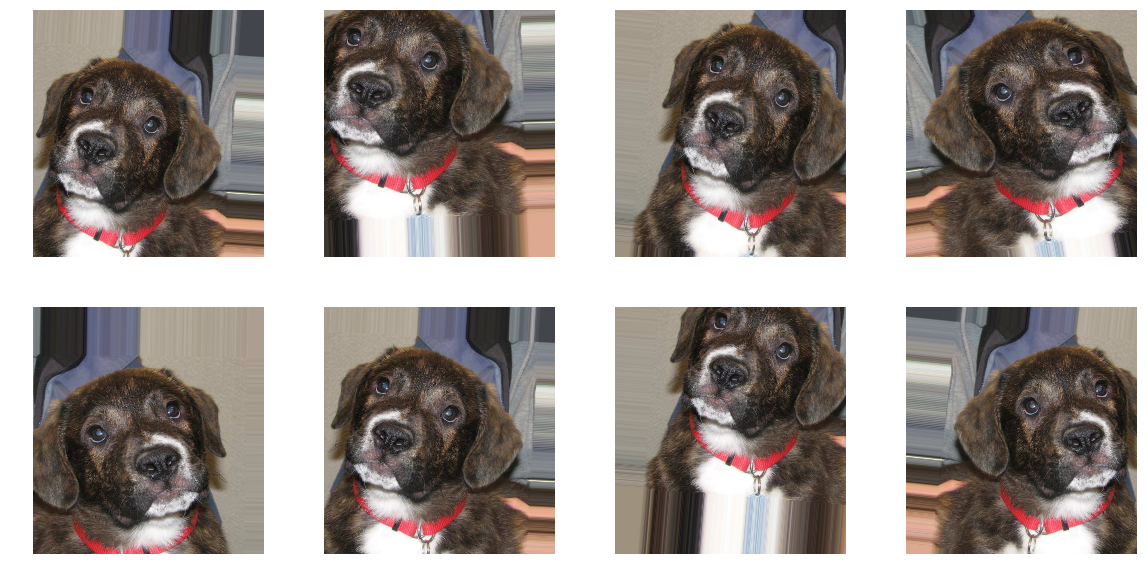

In [4]:
temp_val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True)

from PIL import Image
sample_img = Image.open(glob('./data/dog*.jpg')[0])
sample_img = np.expand_dims(sample_img, axis=0)

i = 0
plt.figure(figsize=(20, 10))
for batch in temp_val_datagen.flow(sample_img):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(np.squeeze(batch))
    
    i += 1
    if i >= 8:
        break

plt.show()

下面，我们调用ImageDataGenerator的flow_from_directory来构造训练集和验证集的generator。注意此处需要指定target_size，这里的方法与VGG论文中有所不同，我们虽然固定了尺寸，但是通过缩放等操作对局部特征进行了缩放，与直接进行原图的缩放效果是相似的。

In [5]:
train_generator = train_datagen.flow_from_directory('./data-for-gen/train', 
                                                    target_size=(ROWS, COLS), batch_size=16, class_mode='binary')

val_generator = val_datagen.flow_from_directory('./data-for-gen/val', 
                                                target_size=(ROWS, COLS), batch_size=16, class_mode='binary')

Found 18748 images belonging to 2 classes.
Found 6252 images belonging to 2 classes.


下面，我们使用keras.applications包中的VGG16模型，进行训练。

### 构建VGG16模型

In [6]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.optimizers import RMSprop

optimizer = RMSprop(lr=1e-4, decay=1e-6) # 优化器使用RMSprop, 设置学习率是1e-4
objective = 'binary_crossentropy' # loss 函数使用交叉熵

base_model = VGG16(weights=None, include_top=False, input_shape=(COLS, ROWS, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(input=base_model.input, output=output)
model.summary()

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
bloc

/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  app.launch_new_instance()


### 训练模型

由于数据增广需要对图像进行旋转、缩放等预处理，因此每一轮的训练时间会更久，**在高性能GPU环境下，每一轮需要几分钟左右，请实践者保持耐心，笔者的实践中，经过44轮的训练精度达到约94%，耗时约3.5小时**。在实践时，我们可以尝试减少ImageDataGenerator的预处理参数，专注于某一项或几项增广对训练产生的影响。也可以适当的减少EarlyStopping的patience，让训练更早的结束，以减少训练时间。


In [ ]:
epochs = 50 # 训练轮数

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')   
mcp = ModelCheckpoint('aug.weights.{epoch:03d}_{acc:.4f}_{val_acc:.4f}.h5', 
                      monitor='val_acc', save_best_only=True, save_weights_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=5, min_lr=1e-9, verbose=1)
# 开始训练
hist = model.fit_generator(
    epochs=epochs,
    generator=train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    shuffle=True,
    callbacks=[early_stopping, mcp, reduce_lr])

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
1172/1172 [==============================] - 290s 248ms/step - loss: 0.6736 - acc: 0.5851 - val_loss: 0.6458 - val_acc: 0.6470

Epoch 00001: val_acc improved from -inf to 0.64699, saving model to aug.weights.001_0.5851_0.6470.h5
Epoch 2/1000
1172/1172 [==============================] - 280s 239ms/step - loss: 0.6298 - acc: 0.6499 - val_loss: 0.5784 - val_acc: 0.7033

Epoch 00002: val_acc improved from 0.64699 to 0.70329, saving model to aug.weights.002_0.6498_0.7033.h5
Epoch 3/1000
1172/1172 [==============================] - 283s 241ms/step - loss: 0.5918 - acc: 0.6974 - val_loss: 0.5719 - val_acc: 0.7313

Epoch 00003: val_acc improved from 0.70329 to 0.73129, saving model to aug.weights.003_0.6974_0.7313.h5
Epoch 4/1000
1172/1172 [==============================] - 280s 239ms/step - loss: 0.5609 - acc: 0.7272 - val_loss: 0.5389 - val_acc: 0.7481

Epoch 00004: val_acc improved from 0.73129 to 0.74808, saving model to aug.weig

### 绘制模型训练结果

在笔者的实践中，模型在第44轮val_acc达到了0.9440，相对于不带增广的训练，精度有一定的提升。

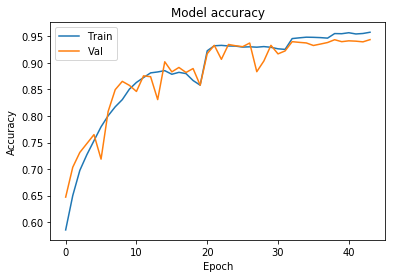

In [10]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的准确率值
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

加入数据增广后，每一轮的训练时间会变得更长（因为每一批数据都需要进行旋转、缩放等预处理），但是增广后的数据特征更加丰富，有利于提高模型的泛化性和精度，也更加适合样本较少的数据集下的训练。

### 扩展

- 尝试调整ImageDataGenerator中的其他参数，并进行组合，查看不同的增广方法对模型训练带来的影响。

- 尝试使用较少的图片做数据集，并加入数据增广进行对比。